## Importing libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import talib
import numpy as np
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report

## Importing Data and Data preprocessing 

In [2]:
df = pd.read_csv('downloads/data.csv')
df.head(5)

,mic,symbol,isin,date,open_value,high_value,low_value,last_value,change_prev_close_percentage,turnover
0,XZAG,CBX,HRZB00ICBEX6,2015-12-30,1689.22,1689.71,1673.62,1689.63,-0.02,2017520.82
1,XZAG,CBX,HRZB00ICBEX6,2015-12-29,1675.79,1691.02,1673.37,1689.94,0.84,1094356.06
2,XZAG,CBX,HRZB00ICBEX6,2015-12-28,1655.92,1677.17,1652.76,1675.88,1.21,1125687.29
3,XZAG,CBX,HRZB00ICBEX6,2015-12-23,1647.66,1655.77,1641.41,1655.77,0.49,592284.75
4,XZAG,CBX,HRZB00ICBEX6,2015-12-22,1655.71,1655.71,1642.60,1647.67,-0.55,2714509.05


In [3]:
#drop columns which are not required
df.drop(columns=['mic','symbol','isin','open_value','change_prev_close_percentage','turnover'],inplace=True)
#reverse all the rows
df = df[::-1]
#convert data column into datetime object
df['date'] = pd.to_datetime(df['date'])
#drop rows with null values
df = df.dropna()
#change column name 
df = df.rename(columns={'last_value':'close','high_value':'high','low_value':'low'})

In [4]:
def feature_construction(df):
    
    df['SMA5'] = talib.SMA(df['close'],timeperiod=5)
    df['SMA10'] = talib.SMA(df['close'],timeperiod=10)
    df['wma5']  = talib.WMA(df['close'],timeperiod=5)
    df['wma10'] = talib.WMA(df['close'],timeperiod=10)
    df['macd'],macd_signal,macd_hist =  talib.MACD(df['close'],fastperiod=12,slowperiod=6)
    df['cci'] = talib.CCI(df['high'],df['low'],df['close'],timeperiod=20)
    df['disparity5'] = df['close'] / talib.SMA(df['close'], timeperiod=5)
    df['disparity10'] = df['close'] / talib.SMA(df['close'], timeperiod=10)
    df['roc'] = talib.ROC(df['close'],timeperiod=10)
    df['rsi'] = talib.RSI(df['close'],timeperiod=14)
    df['momentum'] = talib.MOM(df['close'],timeperiod=10)
    df['ppo'] = talib.PPO(df['close'],fastperiod=5,slowperiod=10)
    df['std'] = talib.STDDEV(df['close'],timeperiod=5)
    df['stoch_k'] = ((df['close'] - talib.MIN(df['low'], timeperiod=14)) / (talib.MAX(df['high'], timeperiod=14) - talib.MIN(df['low'], timeperiod=14))) * 100
    df['stoch_d'] = talib.SMA(df['stoch_k'], timeperiod=3)
    
    df = df.dropna()
    return df


In [5]:
df_feature_constructed = feature_construction(df)

# Create a column for 5-days-ahead direction
df_feature_constructed['5_days_ahead_direction'] = np.where(df_feature_constructed['close'].shift(-5) > df_feature_constructed['close'], 1, 0)

# Create a column for 10-days-ahead direction
df_feature_constructed['10_days_ahead_direction'] = np.where(df_feature_constructed['close'].shift(-10) > df_feature_constructed['close'], 1, 0)

# Drop rows with NaN values in the new columns
df_feature_constructed = df_feature_constructed.iloc[:-10]

# df_feature_constructed = df_feature_constructed.set_index('date')
df_feature_constructed.head(5)

,date,high,low,close,SMA5,SMA10,wma5,wma10,macd,cci,...,disparity10,roc,rsi,momentum,ppo,std,stoch_k,stoch_d,5_days_ahead_direction,10_days_ahead_direction
1478,2010-02-01,2201.41,2186.13,2194.75,2192.798,2175.578,2196.316000,2183.601818,21.908122,95.898027,...,1.008812,1.705793,80.389223,36.81,0.791514,11.426018,78.483908,82.308850,0,0
1477,2010-02-02,2199.24,2183.78,2193.14,2197.286,2179.370,2196.430000,2186.794909,19.298392,90.195090,...,1.006318,1.759449,79.698471,37.92,0.822072,3.573629,72.861443,79.106713,0,0
1476,2010-02-03,2220.65,2197.51,2212.18,2199.976,2183.719,2201.394667,2192.760364,19.383570,121.226434,...,1.013033,2.005358,81.700993,43.49,0.744464,7.034482,91.348675,80.898008,0,0
1475,2010-02-04,2217.05,2178.55,2178.55,2196.404,2184.421,2194.252667,2191.820545,14.148302,77.714733,...,0.997312,0.323274,68.793534,7.02,0.548566,11.224802,58.695019,74.301712,0,0
1474,2010-02-05,2178.54,2134.31,2150.32,2185.788,2183.900,2178.891333,2185.620364,6.639588,-19.645946,...,0.984624,-0.241704,60.196419,-5.21,0.086451,20.694321,31.284591,60.442761,0,1


In [6]:
y = df_feature_constructed['5_days_ahead_direction']
X = df_feature_constructed.iloc[:,[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]]

In [7]:
unique_classes = df_feature_constructed['5_days_ahead_direction'].value_counts()
unique_classes

5_days_ahead_direction
0    801
1    667
Name: count, dtype: int64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Data Analysis

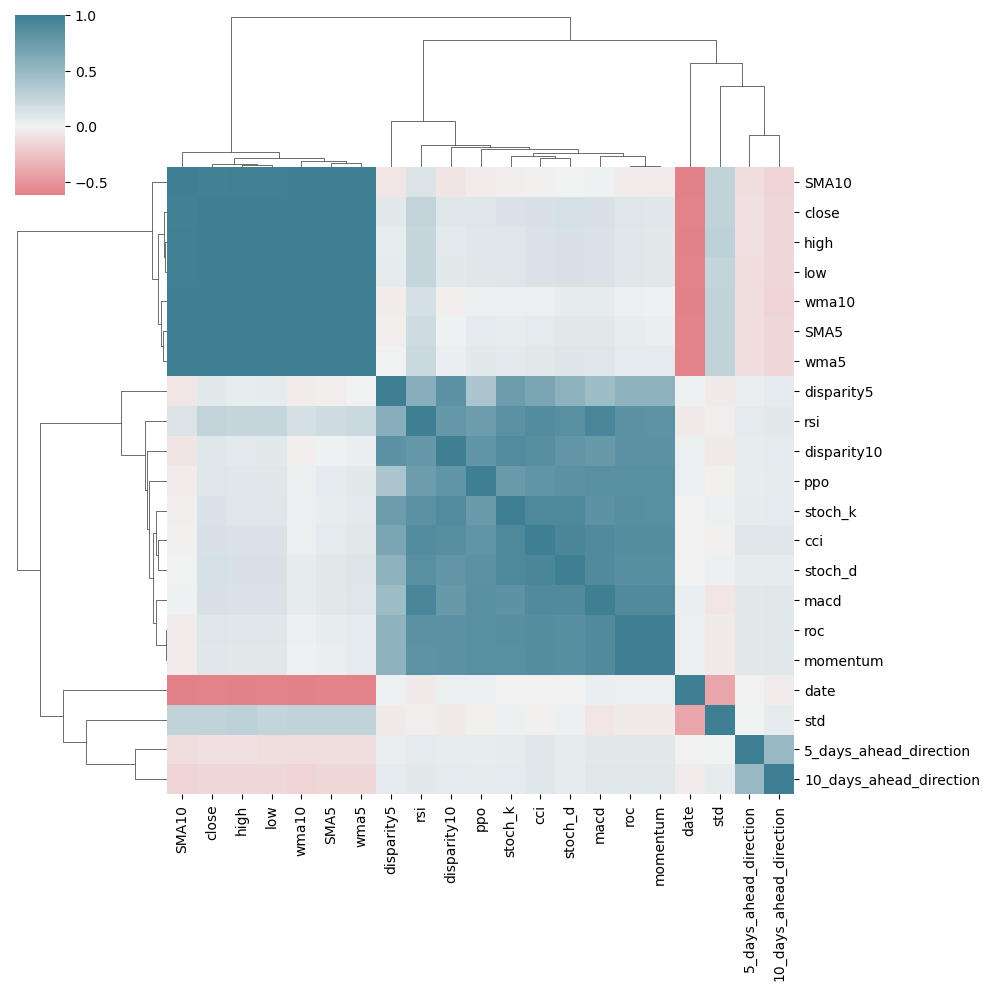

In [9]:
# creating a heat map of the correlation between features
cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.clustermap(
    df_feature_constructed.corr('spearman'),
    center=0,
    cmap=cmap,
    fmt=".2f", 
    annot_kws={"size": 1}, 
    cbar_kws={"orientation": "vertical"}
)

plt.show()

## Model for 5 days ahead direction prediction

In [10]:
classifier_names = ['Random Forest', 'XGBoost', 'LightGBM', 'Deep Neural Network']
accuracy_scores = []
precision_scores = []

### Random Forest Classifier

In [11]:
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42,n_jobs=-1,)
rf_classifier.fit(X_train, y_train)
predictions = rf_classifier.predict(X_test)

In [12]:
rf_accuracy = accuracy_score(y_test, predictions)

conf_matrix = confusion_matrix(y_test, predictions)

tn, fp, fn, tp = conf_matrix.ravel()
rf_recall = tp / (tp + fn)

# Print the results
print("Confusion Matrix:")
print(conf_matrix)
print("\nFalse Positives:", fp)
print("False Negatives:", fn)

accuracy_scores.append(rf_accuracy)
precision_scores.append(rf_recall)
print("\nClassification Report:")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[141  36]
 [ 37  80]]

False Positives: 36
False Negatives: 37

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       177
           1       0.69      0.68      0.69       117

    accuracy                           0.75       294
   macro avg       0.74      0.74      0.74       294
weighted avg       0.75      0.75      0.75       294



### XGBoost Classifier

In [13]:
# Create an XGBoost classifier
xgb_classifier = XGBClassifier(booster='gbtree',device='gpu',objective='binary:logistic',
                                   random_state=42,n_estimators = 800,validate_parameters=True,eta=0.2,max_depth=0)

# Train the classifier on the training data
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test data
predictions = xgb_classifier.predict(X_test)

In [14]:
# Evaluate the accuracy of the model
xgb_accuracy = accuracy_score(y_test, predictions)

# Assuming 'y_test' is the true labels and 'predictions' are the predicted labels
conf_matrix = confusion_matrix(y_test, predictions)

# Extract values from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate recall
xgb_recall = tp / (tp + fn)

# Print the results
print("Confusion Matrix:")
print(conf_matrix)
print("\nFalse Positives:", fp)
print("False Negatives:", fn)

accuracy_scores.append(xgb_accuracy)
precision_scores.append(xgb_recall)
# Additional information using classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[135  42]
 [ 39  78]]

False Positives: 42
False Negatives: 39

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       177
           1       0.65      0.67      0.66       117

    accuracy                           0.72       294
   macro avg       0.71      0.71      0.71       294
weighted avg       0.73      0.72      0.73       294



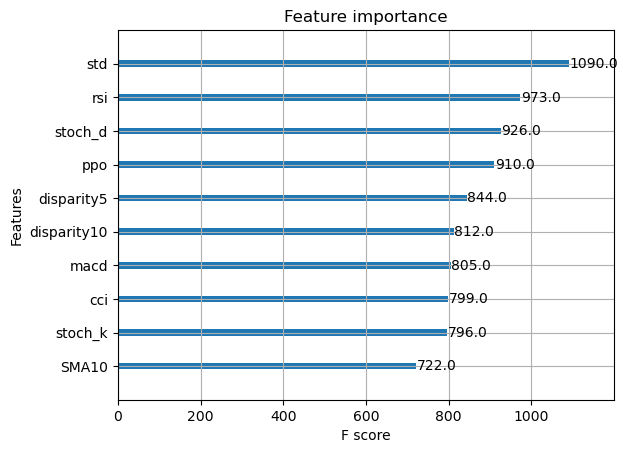

In [15]:
xgb.plot_importance(xgb_classifier, importance_type='weight', max_num_features=10)
plt.show()

### LightGBM classifier

In [16]:
# Convert the data to LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set hyperparameters for LightGBM
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbrt',
    'tree_learner':'voting',
    'num_leaves': 35,
    'learning_rate': 0.2,
    'feature_fraction': 0.8,
    'seed':'100',
    'force_col_wise':'true'
}

# Train the LightGBM model
num_round = 200
lgb_model = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Make predictions on the test data
predictions = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
predictions_binary = (predictions > 0.5).astype(int)

[LightGBM] [Info] Number of positive: 550, number of negative: 624
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 1174, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.468484 -> initscore=-0.126232
[LightGBM] [Info] Start training from score -0.126232


In [17]:
# Evaluate the accuracy of the model
gbm_accuracy = accuracy_score(y_test, predictions_binary)

# Print confusion matrix and classification report
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, predictions_binary)

# Extract values from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate recall
gbm_recall = tp / (tp + fn)

# Print the results
print("Confusion Matrix:")
print(conf_matrix)
print("\nFalse Positives:", fp)
print("False Negatives:", fn)

accuracy_scores.append(gbm_accuracy)
precision_scores.append(gbm_recall)
# Additional information using classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions_binary))


Confusion Matrix:
Confusion Matrix:
[[132  45]
 [ 39  78]]

False Positives: 45
False Negatives: 39

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       177
           1       0.63      0.67      0.65       117

    accuracy                           0.71       294
   macro avg       0.70      0.71      0.70       294
weighted avg       0.72      0.71      0.72       294



### Deep Neural Network

In [18]:
#Importing libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [19]:
# Create a neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the training data
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

2023-12-01 07:48:24.145905: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-12-01 07:48:24.145940: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-01 07:48:24.145956: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-01 07:48:24.146083: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-01 07:48:24.146161: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2023-12-01 07:48:25.233284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 2s 28ms/step - loss: 114.3013 - accuracy: 0.5066 - val_loss: 14.9051 - val_accuracy: 0.4661
Epoch 2/10
33/33 [==============================] - 0s 15ms/step - loss: 20.6360 - accuracy: 0.5000 - val_loss: 4.9947 - val_accuracy: 0.4492
Epoch 3/10
33/33 [==============================] - 1s 16ms/step - loss: 35.1263 - accuracy: 0.4754 - val_loss: 17.0865 - val_accuracy: 0.4661
Epoch 4/10
33/33 [==============================] - 0s 15ms/step - loss: 23.6908 - accuracy: 0.4991 - val_loss: 11.1668 - val_accuracy: 0.4661
Epoch 5/10
33/33 [==============================] - 1s 16ms/step - loss: 18.7328 - accuracy: 0.5227 - val_loss: 15.0841 - val_accuracy: 0.5339
Epoch 6/10
33/33 [==============================] - 0s 14ms/step - loss: 16.7626 - accuracy: 0.4905 - val_loss: 13.0253 - val_accuracy: 0.5339
Epoch 7/10
33/33 [==============================] - 1s 19ms/step - loss: 23.9181 - accuracy: 0.5199 - val_loss: 59.3216 - val_accuracy: 0.5339
Epoch 8/10

In [20]:
# Make predictions on the test data
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)

# Evaluate the accuracy of the model
dl_accuracy = accuracy_score(y_test, predictions)

# Print confusion matrix and classification report
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, predictions)

tn, fp, fn, tp = conf_matrix.ravel()

# Calculate recall
dl_recall = tp / (tp + fn)

# Print the results
print("Confusion Matrix:")
print(conf_matrix)
print("\nFalse Positives:", fp)
print("False Negatives:", fn)
print("Recall (Sensitivity):", dl_recall)

accuracy_scores.append(dl_accuracy)
precision_scores.append(dl_recall)
# Additional information using classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions))

10/10 [==============================] - 0s 7ms/step

Confusion Matrix:
Confusion Matrix:
[[141  36]
 [ 97  20]]

False Positives: 36
False Negatives: 97
Recall (Sensitivity): 0.17094017094017094

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.80      0.68       177
           1       0.36      0.17      0.23       117

    accuracy                           0.55       294
   macro avg       0.47      0.48      0.46       294
weighted avg       0.50      0.55      0.50       294



### Model comparision 

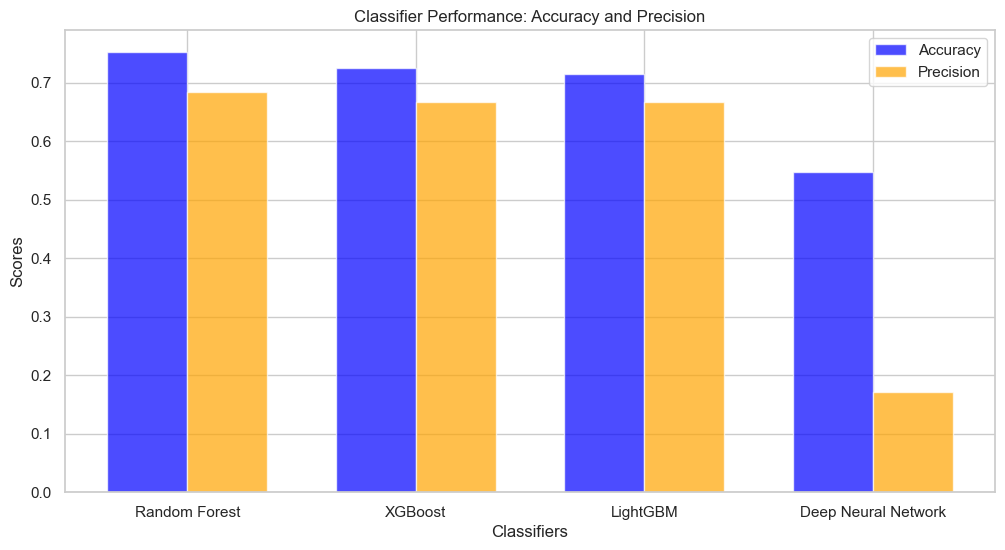

In [21]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.35
bar_positions = range(len(classifier_names))

# Plot accuracy
ax.bar(
    bar_positions,
    accuracy_scores,
    width=bar_width,
    color='blue',
    alpha=0.7,
    label='Accuracy'
)

# Plot precision
ax.bar(
    [pos + bar_width for pos in bar_positions],
    precision_scores,
    width=bar_width,
    color='orange',
    alpha=0.7,
    label='Precision'
)

# Add labels and title
ax.set_xlabel('Classifiers')
ax.set_ylabel('Scores')
ax.set_title('Classifier Performance: Accuracy and Precision')
ax.set_xticks([pos + bar_width / 2 for pos in bar_positions])
ax.set_xticklabels(classifier_names)
ax.legend()

plt.show()

## Model for 10 days ahead direction prediction

### spliting into training and testing data

In [51]:
y = df_feature_constructed['10_days_ahead_direction']
X = df_feature_constructed.iloc[:,[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]]

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
classifier_names = ['Random Forest', 'XGBoost', 'LightGBM', 'Deep Neural Network']
accuracy_scores = []
precision_scores = []

### Random Forest Classifier

In [54]:
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42,n_jobs=-1,)
rf_classifier.fit(X_train, y_train)
predictions = rf_classifier.predict(X_test)

In [55]:
rf_accuracy = accuracy_score(y_test, predictions)

conf_matrix = confusion_matrix(y_test, predictions)

tn, fp, fn, tp = conf_matrix.ravel()
rf_recall = tp / (tp + fn)

# Print the results
print("Confusion Matrix:")
print(conf_matrix)
print("\nFalse Positives:", fp)
print("False Negatives:", fn)

accuracy_scores.append(rf_accuracy)
precision_scores.append(rf_recall)
print("\nClassification Report:")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[139  33]
 [ 29  93]]

False Positives: 33
False Negatives: 29

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       172
           1       0.74      0.76      0.75       122

    accuracy                           0.79       294
   macro avg       0.78      0.79      0.78       294
weighted avg       0.79      0.79      0.79       294



### XGBoost Classifier

In [56]:
# Create an XGBoost classifier
xgb_classifier = XGBClassifier(booster='gbtree',device='gpu',objective='binary:logistic',
                                   random_state=42,n_estimators = 800,validate_parameters=True,eta=0.2,max_depth=0)

# Train the classifier on the training data
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test data
predictions = xgb_classifier.predict(X_test)

In [57]:
# Evaluate the accuracy of the model
xgb_accuracy = accuracy_score(y_test, predictions)

# Assuming 'y_test' is the true labels and 'predictions' are the predicted labels
conf_matrix = confusion_matrix(y_test, predictions)

# Extract values from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate recall
xgb_recall = tp / (tp + fn)

# Print the results
print("Confusion Matrix:")
print(conf_matrix)
print("\nFalse Positives:", fp)
print("False Negatives:", fn)

accuracy_scores.append(xgb_accuracy)
precision_scores.append(xgb_recall)
# Additional information using classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[136  36]
 [ 27  95]]

False Positives: 36
False Negatives: 27

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       172
           1       0.73      0.78      0.75       122

    accuracy                           0.79       294
   macro avg       0.78      0.78      0.78       294
weighted avg       0.79      0.79      0.79       294



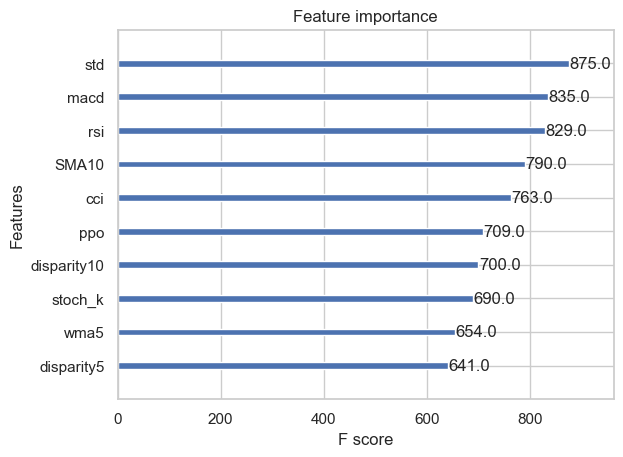

In [58]:
xgb.plot_importance(xgb_classifier, importance_type='weight', max_num_features=10)
plt.show()

### LightGBM classifier

In [59]:
# Convert the data to LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set hyperparameters for LightGBM
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbrt',
    'tree_learner':'voting',
    'num_leaves': 35,
    'learning_rate': 0.2,
    'feature_fraction': 0.8,
    'seed':'100',
    'force_col_wise':'true'
}

# Train the LightGBM model
num_round = 200
lgb_model = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Make predictions on the test data
predictions = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
predictions_binary = (predictions > 0.5).astype(int)

[LightGBM] [Info] Number of positive: 545, number of negative: 629
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 1174, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.464225 -> initscore=-0.143345
[LightGBM] [Info] Start training from score -0.143345


In [60]:
# Evaluate the accuracy of the model
gbm_accuracy = accuracy_score(y_test, predictions_binary)

# Print confusion matrix and classification report
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, predictions_binary)

# Extract values from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate recall
gbm_recall = tp / (tp + fn)

# Print the results
print("Confusion Matrix:")
print(conf_matrix)
print("\nFalse Positives:", fp)
print("False Negatives:", fn)

accuracy_scores.append(gbm_accuracy)
precision_scores.append(gbm_recall)
# Additional information using classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions_binary))


Confusion Matrix:
Confusion Matrix:
[[139  33]
 [ 31  91]]

False Positives: 33
False Negatives: 31

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       172
           1       0.73      0.75      0.74       122

    accuracy                           0.78       294
   macro avg       0.78      0.78      0.78       294
weighted avg       0.78      0.78      0.78       294



### Deep Neural Network

In [61]:
# Create a neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the training data
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
33/33 [==============================] - 2s 35ms/step - loss: 32.4500 - accuracy: 0.5019 - val_loss: 30.2386 - val_accuracy: 0.4661
Epoch 2/10
33/33 [==============================] - 1s 22ms/step - loss: 37.0774 - accuracy: 0.4962 - val_loss: 14.3935 - val_accuracy: 0.4661
Epoch 3/10
33/33 [==============================] - 1s 22ms/step - loss: 16.7348 - accuracy: 0.5000 - val_loss: 13.1676 - val_accuracy: 0.4746
Epoch 4/10
33/33 [==============================] - 1s 39ms/step - loss: 19.4637 - accuracy: 0.4811 - val_loss: 7.8721 - val_accuracy: 0.5169
Epoch 5/10
33/33 [==============================] - 1s 24ms/step - loss: 5.4491 - accuracy: 0.5085 - val_loss: 16.4356 - val_accuracy: 0.5339
Epoch 6/10
33/33 [==============================] - 1s 18ms/step - loss: 7.3959 - accuracy: 0.5038 - val_loss: 5.8307 - val_accuracy: 0.5339
Epoch 7/10
33/33 [==============================] - 1s 20ms/step - loss: 15.5287 - accuracy: 0.4953 - val_loss: 7.6853 - val_accuracy: 0.5339
Epoc

In [62]:
# Make predictions on the test data
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)

# Evaluate the accuracy of the model
dl_accuracy = accuracy_score(y_test, predictions)

# Print confusion matrix and classification report
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, predictions)

tn, fp, fn, tp = conf_matrix.ravel()

# Calculate recall
dl_recall = tp / (tp + fn)

# Print the results
print("Confusion Matrix:")
print(conf_matrix)
print("\nFalse Positives:", fp)
print("False Negatives:", fn)
print("Recall (Sensitivity):", dl_recall)

accuracy_scores.append(dl_accuracy)
precision_scores.append(dl_recall)
# Additional information using classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions))

10/10 [==============================] - 0s 5ms/step

Confusion Matrix:
Confusion Matrix:
[[  0 172]
 [  0 122]]

False Positives: 172
False Negatives: 0
Recall (Sensitivity): 1.0

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       172
           1       0.41      1.00      0.59       122

    accuracy                           0.41       294
   macro avg       0.21      0.50      0.29       294
weighted avg       0.17      0.41      0.24       294



### Model Comparision 

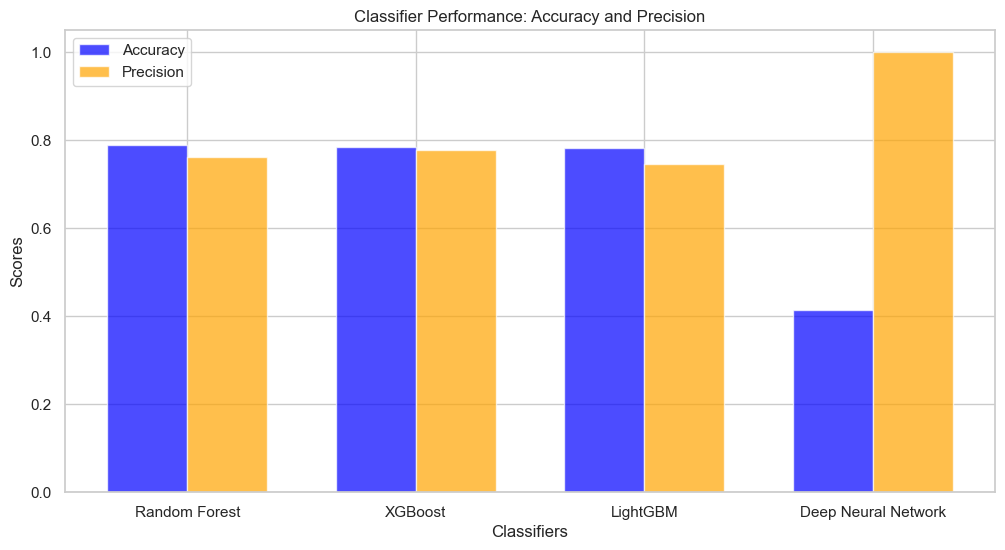

In [63]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.35
bar_positions = range(len(classifier_names))

# Plot accuracy
ax.bar(
    bar_positions,
    accuracy_scores,
    width=bar_width,
    color='blue',
    alpha=0.7,
    label='Accuracy'
)

# Plot precision
ax.bar(
    [pos + bar_width for pos in bar_positions],
    precision_scores,
    width=bar_width,
    color='orange',
    alpha=0.7,
    label='Precision'
)

# Add labels and title
ax.set_xlabel('Classifiers')
ax.set_ylabel('Scores')
ax.set_title('Classifier Performance: Accuracy and Precision')
ax.set_xticks([pos + bar_width / 2 for pos in bar_positions])
ax.set_xticklabels(classifier_names)
ax.legend()

plt.show()